In [1]:
import os
import cv2
import glob
import torch
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import random
import math
from collections import defaultdict
from matplotlib import pyplot as plt
import umap
from torchvision.utils import make_grid
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist 

/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.masks = {}
        
        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)
        
        # Store tumor type in self.labels (0 = nonrecurrent, 1 = recurrent)
        for img in self.image_files:
            slide_num = img.split("/")[-1].split("_")[0][:6]
            tissue_num = img.split("/")[-1].split("_")[0][6:]
            mask_name = slide_num + tissue_num
            
            
            if mask_name not in self.masks:
                self.masks[mask_name] = np.zeros((224, 224), dtype=np.uint8)
            else:
                img_array = np.array(Image.open(img).convert("L"))
                both_zero_mask = (img_array == 0) & (self.masks[mask_name] == 0)
                self.masks[mask_name] = np.where(both_zero_mask, 0, 255).astype(np.uint8)
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
               
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        slide_num = self.image_files[idx].split("/")[-1].split("_")[0][:6]
        tissue_num = self.image_files[idx].split("/")[-1].split("_")[0][6:]
        channel = self.image_files[idx].split("/")[-1][9:-4]
        mask_name = slide_num + tissue_num
        image = Image.open(self.image_files[idx]).convert('L') 
        mask = Image.fromarray(self.masks[mask_name])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, label, mask, channel  # Return image, label, its underlying mask, and its channel (mz mob combination)

In [3]:
# define transformations (if needed)
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_3snr_greyscale/'
dataset = SingleChannelDataset(folder_path, transform=None)
print(dataset[0][1])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

1


In [13]:
def plot_sampled_patches2(image, coordinates, patch_size, ax):
    """
    Plot the original image with bounding boxes indicating the sampled patches.

    Parameters:
        image (np.ndarray): The input image as a NumPy array.
        coordinates (List[Tuple[int, int]]): List of top-left coordinates of sampled patches.
        width (int): width of the patch.
        height (int): height of the patch.
    """
    image_array = np.array(image)
    image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    
    for (x_start, y_start) in coordinates:
        top_left = (y_start, x_start)
        bottom_right = (y_start + patch_size, x_start + patch_size)
        cv2.rectangle(image, top_left, bottom_right, color=(255, 0, 0), thickness=1)

    ax.imshow(image)
    ax.axis('off')  # Turn off axes
    return ax

In [4]:
import numpy as np
from PIL import Image

def construct_patches(img, width=32, height=32):  # Now takes a PIL Image object
    """
    Cuts a PIL Image object into patches and converts each patch to a NumPy array.

    Args:
        img: A PIL Image object.
        width: width of the patch (default: 32 for 224x224 image).
        height: height of the patch (default: 32 for 224x224 image).

    Returns:
        A list of NumPy arrays, where each array represents a patch.
        Returns None if there's an error processing the image.
    """
    img_array = np.array(img)  # Convert PIL Image to NumPy array
    patches = []
    for i in range(0, img_array.shape[0], width):  # Iterate over rows
        for j in range(0, img_array.shape[1], height):  # Iterate over columns
            patch = img_array[i:i + width, j:j + height,:]  # Extract patch
            patches.append(patch)

    return patches
    

In [5]:
def quilting_image(patches_a, patches_b, patch_size, percentage_a=0.5):
    """
    Reconstructs an image by randomly picking patches from two lists,
    with a specified percentage of patches coming from list A.

    Args:
        patches_a: A list of NumPy arrays (patches from image A).
        patches_b: A list of NumPy arrays (patches from image B).
        percentage_a: The percentage of patches to be selected from patches_a (default: 0.5).

    Returns:
        A PIL Image object representing the reconstructed image, or None if there's an error.
    """
    
    
    
    if len(patches_a) != len(patches_b):  # patch counts must match
        raise ValueError("Length of both lists must match!")
    
    num_rows = int(math.sqrt(len(patches_a)))  # number of patches per row is square root of length of patch list
    
    try:
        quilted_image = np.zeros((num_rows * patch_size, num_rows * patch_size), dtype=np.uint8)
        patch_index = 0
        for i in range(num_rows):
            for j in range(num_rows):
                # choose between A and B based on percentage_a
                if random.random() < percentage_a:  # random.random() returns a float between 0 and 1
                    chosen_patch = patches_a[patch_index]
                else:
                    chosen_patch = patches_b[patch_index]

                row_start = i * patch_size
                row_end = row_start + patch_size
                col_start = j * patch_size
                col_end = col_start + patch_size
                quilted_image[row_start:row_end, col_start:col_end] = chosen_patch
                patch_index += 1
        
        return Image.fromarray(quilted_image)

    except Exception as e:
        print(f"Error reconstructing image: {e}")
        return None

In [6]:
def create_patched_image(patches, patch_size):
    # Check if we have the right number of arrays
    patches_per_dimension = 224//patch_size
    if len(patches) != patches_per_dimension**2:
        raise ValueError(f"Number of patches  ({len(patches)})cannot be used to form a 224x224 image given patch size {patch_size}")
    
    # Determine if we're working with grayscale or color images
    if len(patches[0].shape) == 3:
        # Color images
        height, width, channels = patches[0].shape
        result = np.zeros((patches_per_dimension * height, patches_per_dimension * width, channels))
    else:
        # Grayscale images
        height, width = patches[0].shape
        result = np.zeros((patches_per_dimension * height, patches_per_dimension * width))
    
    # Place each array in the correct position
    for i in range(patches_per_dimension):
        for j in range(patches_per_dimension):
            index = i * patches_per_dimension + j
            row_start = i * height
            col_start = j * width
            result[row_start:row_start + height, col_start:col_start + width] = patches[index]
    
    return result

In [7]:
def sample_patches(img, max_patches, patch_size, min_distance):
    """
    Randomly sample n coordinates from white regions (value 255) in a binary image.
    
    Args:
        img: PIL Image or numpy array with binary values (0, 255)
        max_patches: maximum number of patches
        patch_size: the size of the patch
        overlap: acceptable overlap between patches
        
    Returns:
        numpy.ndarray: Array of shape (max_patches, 2) containing (x, y) coordinates
    """
    # convert PIL Image to numpy array if needed
    if isinstance(img, Image.Image):
        img_array = np.array(img)
    else:
        img_array = img
            
    # find coordinates of white pixels in the mask image (value 255)
    white_pixels = np.where(img_array == 255)
    all_coords = np.column_stack((white_pixels[0], white_pixels[1]))
    
    # create a set of tuples for faster membership testing
    # note that we use (y,x) format for coordinates since that's how NumPy indexes images
    coords_set = set(map(tuple, all_coords))
    
    # find valid candidate points that have the bottom right coordinate also in white region
    valid_candidates = []
    valid_indices = []
    

    for idx, (y, x) in enumerate(all_coords):
        factor = random.randint(1, 3)
        bottom_right_coord = (y + patch_size*factor, x + patch_size)  # Note: offset is (x,y) but coords are (y,x)
        if bottom_right_coord in coords_set:
            valid_candidates.append((y, x))
            valid_indices.append(idx)
    
    valid_candidates = np.array(valid_candidates)
    
    # check if we have enough white pixels
    if len(valid_candidates) < max_patches:
        raise ValueError(f"Not enough valid candidates ({len(valid_candidates)}) to sample {max_patches} coordinates")
    
    # create a mask that will be updated to 0 in regions where points are already placed
    # we'll start with all 1s where valid points exist
    point_mask = np.zeros_like(img_array, dtype=bool)
    for y, x in valid_candidates:
        point_mask[y, x] = True
        
    # array to store sampled coordinates
    sampled_coords = []
    
    for _ in range(max_patches):
        # if we've eliminated all possible points, break
        if not np.any(point_mask):
            break
            
        # get indices where mask is True (valid points remain)
        remaining_y, remaining_x = np.where(point_mask)
        remaining_indices = np.arange(len(remaining_y))
        
        # shuffle to randomly sample
        np.random.shuffle(remaining_indices)
        
        # try points in random order
        found_point = False
        for idx in remaining_indices:
            y, x = remaining_y[idx], remaining_x[idx]
            
            # if this point and its offset are both valid
            if (y, x) in coords_set and (y + patch_size, x + patch_size) in coords_set:
                sampled_coords.append((y, x))
                found_point = True
                
                # create a circular mask to remove points that are too close
                y_indices, x_indices = np.ogrid[-y:img_array.shape[0]-y, -x:img_array.shape[1]-x]
                dist_mask = y_indices*y_indices + x_indices*x_indices <= min_distance*min_distance
                point_mask[dist_mask] = False
                
                break
        # we couldn't find another valid point        
        if not found_point:
            break
    
    # check if we got enough samples
    if len(sampled_coords) < max_patches:
        print(f"Warning: Could only find {len(sampled_coords)} points with minimum distance {min_distance} between patches.")
    return sampled_coords

In [8]:
def sample_random_patches_in_mask(mask, n_patches, patch_size, min_distance=5, seed=None):
    """
    Randomly sample n patches within a binary mask with varying widths.
    Ensures minimum distance between patch top-left corners and that entire patches are within the mask.
    
    Parameters:
        mask (np.ndarray): Binary mask where 1/True indicates the object region
        n_patches (int): Number of patches to sample
        patch_size (int): base patch size
        min_distance (int): Minimum distance between top-left corners of patches
        seed (int, optional): Random seed for reproducibility
        
    Returns:
        List[Tuple[int, int, int]]: List of tuples (x_start, y_start, width_multiplier)
                                   where width_multiplier is 1, 2, or 3
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    y_coords, x_coords = np.where(mask > 0)
    
    if len(y_coords) == 0:
        raise ValueError("Mask is empty, no object detected")
    
    # Create array of valid coordinates
    valid_coords = np.column_stack((x_coords, y_coords))
    
    patches = []
    selected_points = []
    mask_height, mask_width = mask.shape[:2]
    
    # Try to sample n patches
    attempts = 0
    max_attempts = n_patches * 100  # Limit attempts to avoid infinite loops
    
    while len(patches) < n_patches and attempts < max_attempts:
        attempts += 1
        
        # Randomly select a point within the mask
        idx = np.random.randint(0, len(valid_coords))
        x, y = valid_coords[idx]
        
        # Randomly select width multiplier (1, 2, or 3)
        width_multiplier = random.choice([1, 2, 3])
        current_width = patch_size * width_multiplier
        
        # Check if the entire patch (including bottom-right) stays within the image bounds
        if x + patch_size > mask_height or y + current_width > mask_width:
            continue
        
        # Check if the entire patch (including bottom-right) is within the mask
        patch_region = mask[x:x+patch_size, y:y+current_width]
        if not np.all(patch_region):
            continue
        
        # Check minimum distance constraint
        if selected_points:
            distances = cdist(np.array([(x, y)]), np.array(selected_points))
            if np.min(distances) < min_distance:
                continue
        
        # Add patch if it meets all criteria
        patches.append((x, y, width_multiplier))
        selected_points.append((x, y))
        
    return patches

def plot_sampled_patches(image, patches, patch_size, ax):
    """
    Plot the original image with bounding boxes indicating the sampled patches.
    
    Parameters:
        image (np.ndarray): The input image as a NumPy array
        patches (List[Tuple[int, int, int]]): List of (x_start, y_start, width_multiplier)
        base_width (int): Base width for patches
        height (int): Height for patches
        ax: Matplotlib axis to plot on
    """
    image_copy = image.copy()
    image_array = np.array(image_copy)
    image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
   
    for (x_start, y_start, width_multiplier) in patches:
        current_width = patch_size * width_multiplier
        top_left = (y_start, x_start)
        bottom_right = (y_start + current_width, x_start + patch_size)
        cv2.rectangle(image, top_left, bottom_right, color=(255, 0, 0), thickness=1)
    
    ax.imshow(image)
    ax.axis('off')  # Turn off axes
    return ax

<Axes: >

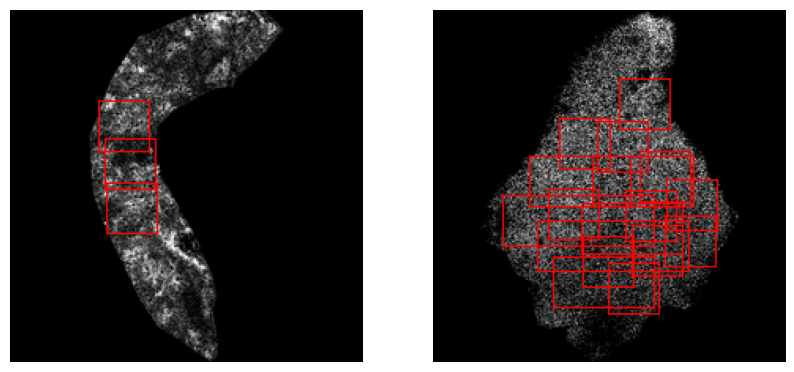

In [10]:

# Display some example images and their sampled coordinates
img1, label1, mask1, channel1 = dataset[1699] # example 1
img2, label2, mask2, channel2 = dataset[400] # example 2

coords1 = sample_random_patches_in_mask(np.array(mask1), 30, 32, 20, 20)
coords2 = sample_random_patches_in_mask(np.array(mask2), 30, 32, 20, 20)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()
plot_sampled_patches(img1, coords1, 32, ax=axes[0])
plot_sampled_patches(img2, coords2, 32, ax=axes[1])

In [9]:
import hashlib
import pickle

def hash_mask(mask):
    """
    Convert a binary mask to a hashable representation.
    
    Args:
        mask: Binary numpy array
        
    Returns:
        String hash that uniquely identifies the mask
    """
    # Convert mask to bytes and hash it
    mask_bytes = pickle.dumps(mask)
    return hashlib.md5(mask_bytes).hexdigest()

def save_patch_cache(filename="patch_cache.pkl"):
    """
    Save the patch cache to disk for persistence between runs
    
    Args:
        filename: Name of the file to save the cache to
    """
    with open(filename, 'wb') as f:
        pickle.dump(_patch_cache, f)
    print(f"Saved cache with {len(_patch_cache)} entries to {filename}")

def load_patch_cache(filename="patch_cache.pkl"):
    """
    Load the patch cache from disk
    
    Args:
        filename: Name of the file to load the cache from
        
    Returns:
        True if cache was loaded successfully, False otherwise
    """
    global _patch_cache
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            _patch_cache = pickle.load(f)
        print(f"Loaded cache with {len(_patch_cache)} entries from {filename}")
    else:
        print("Cache file not found! Initializing cache")

In [10]:
_patch_cache = {} # initialize patch cache
#load_patch_cache("patch_cache.pkl") # load patch cache from pickle file if possible

In [11]:
from matplotlib.patches import Rectangle


def sample_patches_from_mask(mask, patch_size=32, stride=16, overlap_threshold=0.5):
    
    height, width = mask.shape
    valid_patches = []
    

    # create a hashable version of the mask if caching is enabled
    mask_hash = hash_mask(mask) # convert the mask into a hash to check if the mask has been cached
    cache_key = (mask_hash, patch_size, stride, overlap_threshold)
    
    # check if we already computed patches for this mask
    """if cache_key in _patch_cache:
        print("Using cached patch coordinates")
        return _patch_cache[cache_key]"""
    
    y = 0
    while y + patch_size <= height:
        x = 0
        while x + patch_size <= width:
            # calculate the overlap between the patch and the mask
            patch_area = patch_size * patch_size
            overlap_count = 0
            
            for py in range(y, y + patch_size):
                for px in range(x, x + patch_size):
                    if mask[px, py]:
                        overlap_count += 1
                
            # calculate overlap ratio
            overlap_ratio = overlap_count / patch_area
            
            # add patch if overlap meets the threshold
            if overlap_ratio >= overlap_threshold:
                valid_patches.append((x, y))
            x += stride
        y += stride
        
        # find the leftmost point in the mask for this row
        if y < height:
            left_x = width  # Initialize to max width
            for x in range(width):
                if mask[x, y]:
                    left_x = x
                    break

            else:
                # keep moving down until we find a row with mask points
                found_next_row = False
                while y < height and not found_next_row:
                    for x in range(width):
                        if y < height and mask[x, y]:
                            found_next_row = True
                            break
                    if not found_next_row:
                        y += stride
                        
    _patch_cache[cache_key] = valid_patches # store the patches found into a cache before returning 
    return valid_patches


<Axes: >

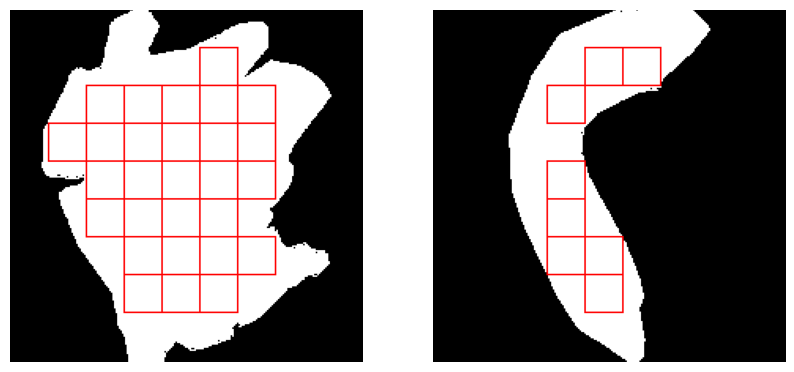

In [16]:

# Display some example images and their sampled coordinates
img1, label1, mask1, channel1 = dataset[100] # example 1
img2, label2, mask2, channel2 = dataset[1500] # example 2

coords1 = sample_patches_from_mask(np.array(mask1), 24, 24, 1)
coords2 = sample_patches_from_mask(np.array(mask2), 24, 24, 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()
plot_sampled_patches2(mask1, coords1, 24, ax=axes[0])
plot_sampled_patches2(mask2, coords2, 24, ax=axes[1])

In [17]:
def extract_patches(image, coordinates, patch_size):
    """
    Extract patches from an image using the given coordinates.

    Parameters:
        image (np.ndarray): The input image as a NumPy array.
        coordinates (List[Tuple[int, int]]): List of top-left coordinates of patches.
        patch_size (int): Size of the square patch.

    Returns:
        List[np.ndarray]: A list of extracted patches as NumPy arrays.
    """
    patches = [
        image[x_start:x_start + patch_size, y_start:y_start + patch_size]
        for x_start, y_start in coordinates
    ]
    return patches

def create_patches_by_channel(dataset, patch_size=32, stride=16, overlap=0.25):
    """
    Construct a quited image dataset synthesized existing Dataset object

    Args:
        dataset: a Dataset object that contains the images
        max_patches: maximum number of patches that can be drawn on the image
        patch_size: the size of the patches
        overlap: how much two patches can overlap each other

    Returns:
        A directory containing generated quilted images
    """
    positive_patches_by_channel = defaultdict(list)
    negative_patches_by_channel = defaultdict(list)
    for img, label, mask, channel in dataset:
        coords = sample_patches_from_mask(np.array(mask), patch_size, stride, overlap) # sample maximum 32 patches of size 8x8
        patches = extract_patches(np.array(img), coords, patch_size)
        if label == 1:
            positive_patches_by_channel[channel].extend(patches)
        else:
            negative_patches_by_channel[channel].extend(patches)
    return positive_patches_by_channel, negative_patches_by_channel

positive_patches, negative_patches = create_patches_by_channel(dataset, 24, 40, 1)

In [18]:
patch_size = 32
num_patches = (224 // patch_size) ** 2
positive_quilts_train = defaultdict(list)
positive_quilts_test = defaultdict(list)
negative_quilts_train = defaultdict(list)
negative_quilts_test = defaultdict(list)

all_channels = list(positive_patches.keys())
for channel in all_channels:
    # shuffle the patches up first
    positive_patches_train, positive_patches_test = train_test_split(positive_patches[channel], test_size= 0.3, random_state=42)
    negative_patches_train, negative_patches_test = train_test_split(negative_patches[channel], test_size= 0.3, random_state=42)

    # create numpy arrays of quilted images
    for i in range(0, len(positive_patches_train), num_patches):
        random.shuffle(positive_patches_train)
        random.shuffle(negative_patches_train)
        random.shuffle(positive_patches_test)
        random.shuffle(negative_patches_test)
        if i + num_patches <= len(positive_patches_train): # if the remaining number of patches are not enough to make a picture, ignore them

            positive_quilts_train[channel].append(quilted_np)

    for i in range(0, len(positive_patches_test), num_patches):
        if i + num_patches <= len(positive_patches_test):
            quilted_np = create_patched_image(positive_patches_test[i:i + num_patches], patch_size)
            positive_quilts_test[channel].append(quilted_np)

    for i in range(0, len(negative_patches_train), num_patches):
        if i + num_patches <= len(negative_patches_train):
            quilted_np = create_patched_image(negative_patches_train[i:i + num_patches], patch_size)
            negative_quilts_train[channel].append(quilted_np)

    for i in range(0, len(negative_patches_test), num_patches):
        if i + num_patches <= len(negative_patches_test):
            quilted_np = create_patched_image(negative_patches_test[i:i + num_patches], patch_size)
            negative_quilts_test[channel].append(quilted_np)
    

NameError: name 'quilted_np' is not defined

In [ ]:
output_folder = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/"
positive_quilted_train = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/positive_train/"
positive_quilted_test = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/positive_test/"
negative_quilted_train = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/negative_train/"
negative_quilted_test = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/negative_test/"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(positive_quilted_train, exist_ok=True)
os.makedirs(positive_quilted_test, exist_ok=True)
os.makedirs(negative_quilted_train, exist_ok=True)
os.makedirs(negative_quilted_test, exist_ok=True)
# Save each array as a grayscale image
min_train_tissues = float('inf')
min_test_tissues = float('inf')
for channel in positive_quilts_train.keys():
    min_train_tissues = min(min_train_tissues, len(positive_quilts_train[channel]), len(negative_quilts_train[channel]))
    min_test_tissues = min(min_test_tissues, len(positive_quilts_test[channel]), len(negative_quilts_test[channel]))
for channel in positive_quilts_train.keys():
    for i in range(min_train_tissues):
        img = Image.fromarray(positive_quilts_train[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(positive_quilted_train, f"Train_positive_{i}_{channel}.png"))

        img = Image.fromarray(negative_quilts_train[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(negative_quilted_train, f"Train_negative_{i}_{channel}.png"))
    for i in range(min_test_tissues):
        img = Image.fromarray(positive_quilts_test[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(positive_quilted_test, f"Test_positive_{i}_{channel}.png"))

        img = Image.fromarray(negative_quilts_test[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(negative_quilted_test, f"Test_negative_{i}_{channel}.png"))


In [ ]:
output_folder = "grayscale_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Assuming you have a list of numpy arrays
numpy_arrays = [array1, array2, array3]  # Replace with your actual array list

# Save each array as a grayscale image
for i, array in enumerate(numpy_arrays):
    # Convert numpy array to PIL Image
    # Mode 'L' is for grayscale
    img = Image.fromarray(array.astype(np.uint8), mode='L')
    
    # Save the image with a sequential filename
    img.save(os.path.join(output_folder, f"image_{i}.png"))


In [ ]:
class CustomQuiltedDataset(Dataset):
    def __init__(self, positive_quilts, negative_quilts, transform=None):
        self.images = []
        self.labels = []
        print(len(positive_quilts), len(negative_quilts))
        self.images.extend(positive_quilts)
        self.images.extend(negative_quilts)
        self.labels.extend([1] * len(positive_quilts))
        self.labels.extend([0] * len(negative_quilts))
        self.transform = transform
                
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

quilted_dataset = CustomQuiltedDataset(positive_quilts, negative_quilts, transform=transform)
quilted_dataloader = DataLoader(quilted_dataset, batch_size=32, shuffle=True)

5000 5000


In [ ]:
print(len(quilted_dataset.labels))

10000


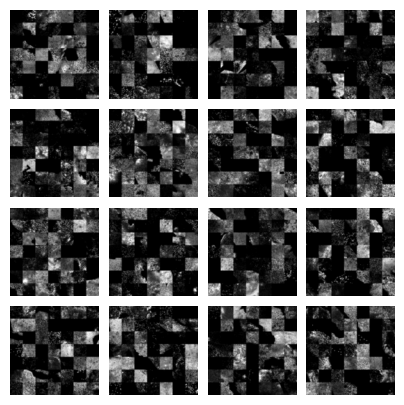

In [ ]:
# Get a batch of 25 images for visualization
dataiter = iter(quilted_dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder convolutional layers
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # For grayscale input
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        # Calculate the flattened size after convolutions
        self.flattened_shape, self.flattened_size = self._get_flattened_size(input_shape)
        
        # Encoder fully connected layers
        self.enc_fc1 = nn.Linear(self.flattened_size, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        # Decoder fully connected layers
        self.dec_fc1 = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, self.flattened_size)

        # Decoder convolutional layers
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def _get_flattened_size(self, input_shape):
        """Pass a dummy input through conv layers to determine the flattened size."""
        x = torch.zeros(1, *input_shape)  # Create a dummy input
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        flattened_shape = x.shape[1:]  # Save shape for reshaping in decoder
        flattened_size = x.numel()     # Total size after flattening
        return flattened_shape, flattened_size

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.enc_fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.dec_fc1(z))
        x = F.relu(self.dec_fc2(x))
        x = x.view(-1, *self.flattened_shape)  # Dynamically reshape to match encoder output
        x = F.relu(self.dec_conv1(x))
        x = torch.sigmoid(self.dec_conv2(x))  # Output in [0, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div

In [ ]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 10
epochs = 20
learning_rate = 1e-3

# Model, optimizer, and device setup
device = torch.device("cuda")
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loss = []
epoch_times = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    start_time = time.time()  # Start timer for epoch
    
    for images, labels in quilted_dataloader:  # Assuming dataloader is your DataLoader for the images
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = model(images)
        
        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    end_time = time.time()
    
    avg_loss = train_loss / len(dataloader)
    training_loss.append(avg_loss)
    
    # Calculate and store epoch duration
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_duration:.2f} sec")

Epoch 1/20, Loss: 263343.0046, Time: 8.01 sec
Epoch 2/20, Loss: 249316.8423, Time: 7.56 sec
Epoch 3/20, Loss: 248772.5740, Time: 7.48 sec
Epoch 4/20, Loss: 248577.9670, Time: 7.70 sec
Epoch 5/20, Loss: 247830.2513, Time: 8.51 sec
Epoch 6/20, Loss: 246552.6743, Time: 7.77 sec
Epoch 7/20, Loss: 245197.1722, Time: 7.51 sec
Epoch 8/20, Loss: 244175.0941, Time: 7.70 sec
Epoch 9/20, Loss: 243881.9165, Time: 7.67 sec
Epoch 10/20, Loss: 243704.5084, Time: 8.35 sec
Epoch 11/20, Loss: 243580.3844, Time: 7.76 sec
Epoch 12/20, Loss: 243104.2206, Time: 8.05 sec
Epoch 13/20, Loss: 242800.5825, Time: 7.47 sec
Epoch 14/20, Loss: 242681.4947, Time: 7.40 sec
Epoch 15/20, Loss: 242593.3031, Time: 7.59 sec
Epoch 16/20, Loss: 242531.3805, Time: 7.11 sec
Epoch 17/20, Loss: 242474.1939, Time: 7.47 sec
Epoch 18/20, Loss: 242408.1198, Time: 7.34 sec
Epoch 19/20, Loss: 242327.6413, Time: 7.21 sec
Epoch 20/20, Loss: 242311.9190, Time: 7.10 sec


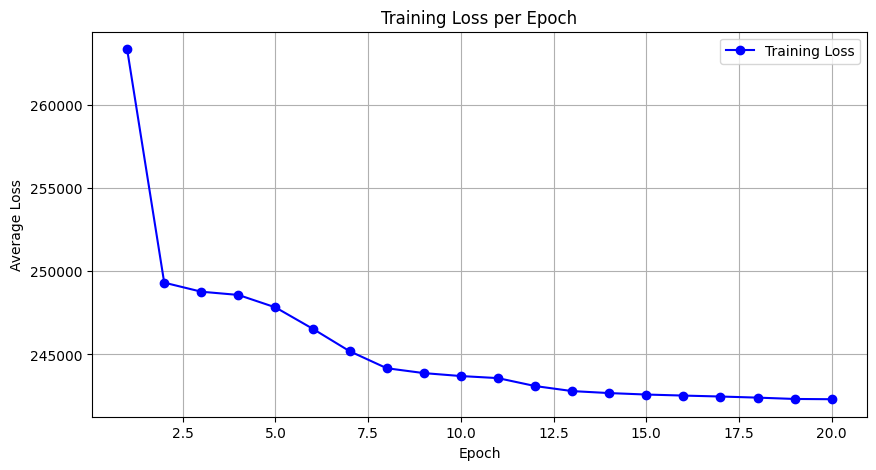

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_loss, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

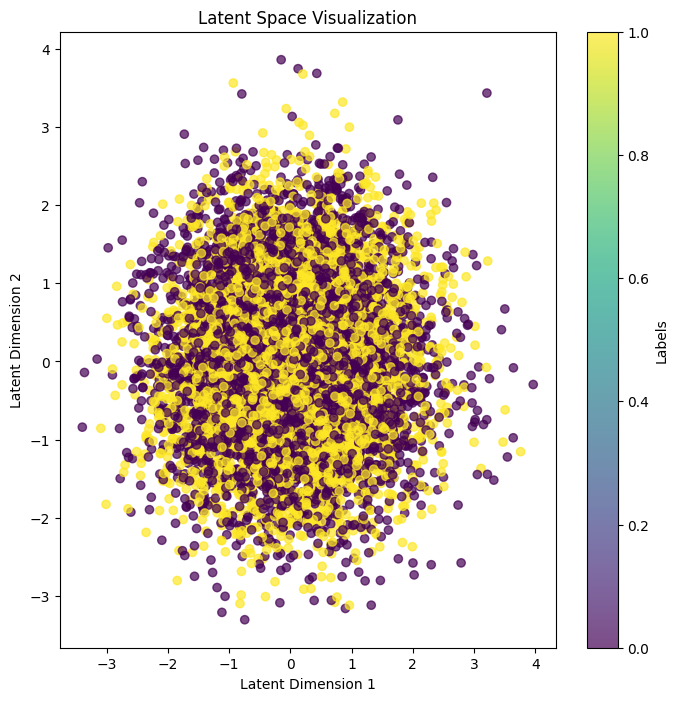

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def visualize_latent_space(model, dataloader, latent_dim=2, use_tsne=False):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use the mean for visualization
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    if latent_dim > 2:
        if use_tsne:
            latents_2d = TSNE(n_components=2).fit_transform(latents)
        else:
            latents_2d = PCA(n_components=2).fit_transform(latents)
    else:
        latents_2d = latents  # If already 2D, no reduction needed

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Labels")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

visualize_latent_space(model, quilted_dataloader, latent_dim=10, use_tsne=False)


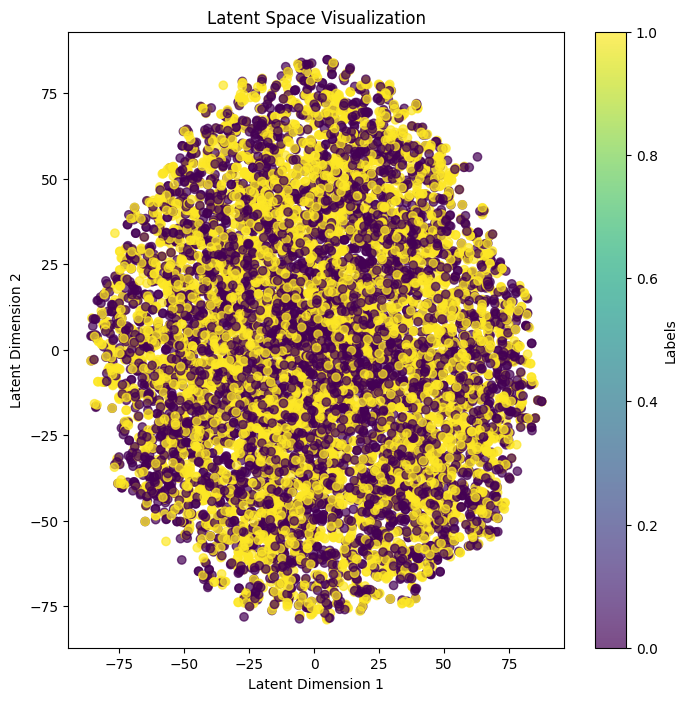

In [ ]:
visualize_latent_space(model, quilted_dataloader, latent_dim=10, use_tsne=True)

In [ ]:

def extract_pattern(input_path, output_path, threshold=100):

    pil_image = Image.open(input_path)
    
    opencv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    
    # convert to grayscale
    gray = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)
    
    # Create binary mask for dark lines
    # Pixels below threshold are considered part of the pattern
    _, binary_mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # create white background
    height, width = gray.shape
    white_background = np.ones((height, width), dtype=np.uint8) * 255
    
    extracted_pattern = np.where(binary_mask == 0, 0, 255).astype(np.uint8)
    
    cv2.imwrite(output_path, extracted_pattern)
    
    return extracted_pattern

extract_pattern("../data/tiling.webp", "../data/output_shape.png", 50)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [19]:
"""
A four-coloring of the Einstein tiling.

Ref:
    "An Aperiodic Monotile" by Smith, et al.
    https://cs.uwaterloo.ca/~csk/hat/
    
This script is modified to extract a binary mask of the first tile generated,
cropped to its bounding box.
"""

import numpy as np
import math
from fractions import Fraction as F
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Polygon, PathPatch
from pysat.solvers import Glucose3
import io
from PIL import Image, ImageDraw # Added ImageDraw
import json

class Qr3(object):
    def __init__(self, a: F, b: F):
        self.a = a
        self.b = b
    
    @property
    def real(self):
        return self.a + 1.73205080757 * self.b
    
    def __float__(self):
        return self.real
    
    def __repr__(self):
        if self.a == 0 and self.b == 0:
            return "0"
        
        if self.b == 0:
            return str(self.a)
        
        b = "√3" if abs(self.b) == 1 else f"{abs(self.b)}√3"
        if self.a == 0:
            return b
        
        return f"{self.a} + {b}" if self.b > 0 else f"{self.a} - {b}"
    
    def __eq__(self, other):
        return self.a == other.a and self.b == other.b
    
    def __add__(self, other):
        return Qr3(self.a + other.a, self.b + other.b)
    
    def __sub__(self, other):
        return Qr3(self.a - other.a, self.b - other.b)
    
    def __mul__(self, other):
        return Qr3(self.a * other.a + 3 * self.b * other.b, self.a * other.b + self.b * other.a)
    
    def __truediv__(self, other):
        a = self.a * other.a - 3 * self.b * other.b
        b = self.b * other.a - self.a * other.b
        d = other.a**2 - 3 * other.b**2
        return Qr3(a / d, b / d)

ONE = np.array([Qr3(1, 0), Qr3(0, 0)])
ROT30 = np.array([[Qr3(0, F(1,2)), Qr3(F(1,2), 0)],
                  [Qr3(F(-1,2), 0), Qr3(0, F(1,2))]])

class Tile(object):
    def __init__(self, tiles, bounds):
        self.tiles = tiles
        self.b = bounds
        
    def add(self, dx):
        self.b += dx
        for tile in self.tiles:
            tile.add(dx)
        return self
            
    def mul(self, M):
        self.b = self.b @ M
        for tile in self.tiles:
            tile.mul(M)
        return self
            
    def copy(self):
        return Tile(
            [tile.copy() for tile in self.tiles],
            self.b.copy()
        )
            
    def flatten(self):
        tiles = []
        for tile in self.tiles:
            tiles.extend(tile.flatten())
        return tiles
    
class Base(Tile):
    def __init__(self, x, bounds):
        self.x = x
        self.b = bounds
        
    def add(self, dx):
        self.x += dx
        self.b += dx
        return self
        
    def mul(self, M):
        self.x = self.x @ M
        self.b = self.b @ M
        return self
    
    @property
    def edges(self):
        return (self.x + np.roll(self.x, 1, axis=0)) / Qr3(2, 0)
    
    def copy(self):
        return Base(self.x.copy(), self.b.copy())
        
    def flatten(self):
        return [self]

def bases(a, b):
    # Edges of a single tile in (length, angle) format:
    e = [
        [a, 12], [a, 10], [b, 1], [b, 11], [a, 8], [a, 10], [b, 7],
        [b, 9], [a, 6], [a, 4], [a, 4], [a, 2], [b, 5],
    ]
    
    # Get the tile coordinates
    dx = np.array([np.linalg.matrix_power(ROT30, angle) @ r for r, angle in e])
    x = np.r_[[[Qr3(0,0), Qr3(0,0)]], np.cumsum(dx, axis=0)]
    
    # The quasi-boundary comes from four points
    b = x[(1, 3, 9, 13), :]
    
    # Get the flipped tile
    y = x[::-1].copy()
    y[:, 1] *= Qr3(-1, 0)
    
    # And move it to be flush with the original tile
    y += x[0] - y[5]
    c = y[(1, 3, 9, 13), :]
    
    # Return two base tiles: the single (H8) and the compound (H7)
    return Base(x, b), Tile([Base(x, b), Base(y, c)], b)

def supers(subtiles):
    rules = [
		[2, 2, 0, 0],
		[4, 2, 0, 0],
		[12, 1, 1, 1],
		[8, 2, 2, 0],
		[10, 2, 0, 0], 
		[12, 2, 0, 0],
    ]
    
    tiles = [subtiles[0]]
    for angle, pivot, anchor, subtile in rules:
        # Rotation matrix
        M = np.linalg.matrix_power(ROT30, angle)
        
        # Rotate and translate subtile
        T = subtiles[subtile].copy().mul(M)
        T.add(tiles[-1].b[anchor] - T.b[pivot])
        
        tiles.append(T)
    
    bounds = [tiles[1].b[3], tiles[2].b[0],
              tiles[4].b[3], tiles[6].b[0]]
    
    return Tile(tiles, bounds), Tile(tiles[:-1], bounds)

def neighbors(tiles):
    e = []
    for i, t1 in enumerate(tiles):
        for j, t2 in enumerate(tiles):
            if i <= j: continue
            if np.sum(np.all(t1.x[:, None, :] == t2.x, axis=-1)) >= 2:
                e.append((i, j))
    return e

def square_crop(tiles, half_width=25):
    """
    Return tiles whose centroid falls within a square window centered at the tiling center.
    half_width: half the side length of the square (i.e., square is 2*half_width wide)
    """
    if not tiles:
        return []
    G = sum(t.x.astype(float) for t in tiles).mean(axis=0) / len(tiles)

    def inside_square(t):
        centroid = t.x.astype(float).mean(axis=0)
        dx, dy = centroid - G
        return abs(dx) <= half_width and abs(dy) <= half_width

    return list(filter(inside_square, tiles))

    """
    Generates a binary mask of a single tile from its vertices.
    
    Args:
        tile_vertices (np.ndarray): A numpy array of shape (N, 2) containing the
                                     (x, y) coordinates of the tile's vertices.
        dpi (int): The DPI for rendering the mask. Higher DPI gives a more detailed mask.

    Returns:
        PIL.Image: A PIL Image object representing the binary mask, cropped to the
                   bounding box of the tile.
        tuple: (x, y, width, height) of the bounding box.
    """
    # Convert vertices to float
    vertices_float = tile_vertices.astype(float)

    # Calculate bounding box for the tile
    min_x, min_y = np.min(vertices_float, axis=0)
    max_x, max_y = np.max(vertices_float, axis=0)
    
    # Add a small buffer to the bounding box to ensure the entire tile is captured
    buffer = 0.5 
    min_x -= buffer
    min_y -= buffer
    max_x += buffer
    max_y += buffer
    
    width = max_x - min_x
    height = max_y - min_y
    
    # Create a Path object from the vertices
    path = Path(vertices_float)
    patch = PathPatch(path, facecolor='black', edgecolor='none')

    # Create a temporary figure and axes for rendering the patch
    # The size of the figure is determined by the bounding box of the tile
    fig_temp = plt.figure(figsize=(width, height), dpi=dpi, frameon=False)
    ax_temp = fig_temp.add_axes([0, 0, 1, 1])  # Use the whole figure for the plot
    
    ax_temp.set_xlim(min_x, max_x)
    ax_temp.set_ylim(min_y, max_y)
    ax_temp.set_aspect('equal')
    ax_temp.axis('off')  # Turn off axes
    
    ax_temp.add_patch(patch)
    
    # Render the figure to a buffer in memory
    buf = io.BytesIO()
    fig_temp.savefig(buf, format='png', transparent=True, bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    
    # Close the temporary figure to free memory
    plt.close(fig_temp)
    
    # Open the image from the buffer
    img = Image.open(buf)
    
    # Convert the image to a NumPy array and get the alpha channel
    # The alpha channel acts as the mask
    img_array = np.array(img)
    alpha_channel = img_array[:, :, 3] > 0  # True for non-transparent pixels
    
    # Convert the boolean mask to a binary integer mask (0 or 1)
    binary_mask = alpha_channel.astype(np.uint8) * 255
    
    # Create a new PIL Image from the binary mask data
    mask_img = Image.fromarray(binary_mask, mode='L')
    
    # Get the bounding box in pixel coordinates after rendering
    bbox_in_pixels = img.getbbox()
    
    # Crop the mask to the rendered bounding box
    cropped_mask = mask_img.crop(bbox_in_pixels)
    
    return cropped_mask, (min_x, min_y, width, height)

In [22]:
# define parameters
output_width_px = 1000
output_height_px = 1000
base_dpi = 100
figsize_width_inches = output_width_px / base_dpi
figsize_height_inches = output_height_px / base_dpi

# generate tiles
H = bases(ONE, ONE) 
# apply the substitution rules multiple times to generate a larger tiling
for i in range(4): # 4 iterations generate a sufficiently complex pattern
    H = supers(H)

# flatten the hierarchy and crop the visible tiles
tiles = H[1].flatten()
tiles = square_crop(tiles, half_width=35)
print("Number of tiles: ", len(tiles))

for channel in positive_patches.keys():
   
    fig, ax = plt.subplots(figsize=(figsize_width_inches, figsize_height_inches), constrained_layout=True)
    ax.set_aspect('equal')
    ax.set_axis_off()

    # determine overall data limits to properly set xlim/ylim for a tight, square fit
    all_vertices = np.concatenate([t.x.astype(float) for t in tiles])
    min_x_data, min_y_data = np.min(all_vertices, axis=0)
    max_x_data, max_y_data = np.max(all_vertices, axis=0)

    data_width = max_x_data - min_x_data
    data_height = max_y_data - min_y_data
    max_data_dim = max(data_width, data_height)

    buffer_factor = 1.05 
    scaled_max_data_dim = max_data_dim * buffer_factor

    center_x = (min_x_data + max_x_data) / 2
    center_y = (min_y_data + max_y_data) / 2

    ax.set_xlim(center_x - scaled_max_data_dim / 2, center_x + scaled_max_data_dim / 2)
    ax.set_ylim(center_y - scaled_max_data_dim / 2, center_y + scaled_max_data_dim / 2)
    # iterate through all tiles and fill each with a random patch
    for i, tile in enumerate(tiles):
        vertices_float = tile.x.astype(float)
        # if there is not enough patches in the channel to fill all tiles, randomly fill the remaining tiles with duplicate patches
        if i < len(positive_patches[channel]):
            patch_array = positive_patches[channel][i]
        # get a random patch from the source image
        else:
            patch_array = random.choice(positive_patches[channel])
        # calculate the bounding box of the current tile
        min_x, min_y = np.min(vertices_float, axis=0)
        max_x, max_y = np.max(vertices_float, axis=0)

        # create an imshow artist for the patch, with its extent set to the tile's bounding box
        # zorder=1 to place it below the outlines
        image_artist = ax.imshow(patch_array, extent=[min_x, max_x, min_y, max_y], 
                                    aspect='auto', zorder=1, cmap='gray')

        # facecolor and edgecolor are 'none' as it's only a mask
        path_patch = PathPatch(Path(vertices_float), facecolor='none', edgecolor='none', lw=0, zorder=2)
        ax.add_patch(path_patch)

        # set the clipping path of the image to the path patch
        image_artist.set_clip_path(path_patch)

        
    print(f"Generating positive_tiles_{channel}.png")
    plt.savefig(f"../data/einstein_tiles/positive/positive_tiles_{channel}.png", pad_inches=0, transparent=True, bbox_inches='tight', dpi=100)
    plt.close(fig)
    

Number of tiles:  570
Generating positive_tiles_704.389_1.30.png
Generating positive_tiles_767.499_1.40.png
Generating positive_tiles_536.291_1.15.png
Generating positive_tiles_636.888_1.08.png
Generating positive_tiles_739.466_1.37.png
Generating positive_tiles_854.660_1.53.png
Generating positive_tiles_742.532_1.42.png
Generating positive_tiles_578.520_1.28.png
Generating positive_tiles_1334.916_1.54.png
Generating positive_tiles_798.543_1.46.png
Generating positive_tiles_827.576_1.48.png
Generating positive_tiles_588.305_1.18.png
Generating positive_tiles_727.513_1.40.png
Generating positive_tiles_632.331_1.25.png
Generating positive_tiles_852.644_1.53.png
Generating positive_tiles_575.503_1.27.png
Generating positive_tiles_778.474_1.39.png
Generating positive_tiles_996.533_1.56.png
Generating positive_tiles_764.471_1.37.png
Generating positive_tiles_821.531_1.45.png
Generating positive_tiles_407.959_1.06.png
Generating positive_tiles_740.518_1.40.png
Generating positive_tiles_774.5

In [ ]:
positive_p